# Initial tests of keras tuner for LSTM motion prediction

# load preliminaries as before

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import cv2
import yaml
import os
import glob
import pickle as pkl
import sys
import importlib

In [ ]:
# load yaml configuration file w/ keypoints dict ()
# assumes ..\ is root of project
# e.g. C:\MLprojects\motion_analysis\configs\config_analysis.yaml

# set up paths
ROOT_DIR = r"c:\MLprojects\motion_analysis"
CONFIG_DIR = "configs"

def load_config(config_name):
    with open(os.path.join(ROOT_DIR, CONFIG_DIR, config_name)) as file:
        config = yaml.full_load(file)
    return config

CONFIG_KEYPOINTS = load_config(r"keypoints.yaml")
CONFIG_EDGE_COLORS = load_config(r"edge_colors.yaml")
PARAMS = load_config(r"analysis_parameters.yaml")

# Confidence score to determine whether a keypoint prediction is reliable, e.g. for cropping algorithm during inference
KEYPOINT_THRESH_SCORE_CROP = load_config('analysis_parameters.yaml')['KEYPOINT_THRESH_SCORE_CROP']


In [ ]:
os.chdir(ROOT_DIR)

In [ ]:
# custom modules
from src.io import iomod
from src.inference import inference
from src.visualization import draw
from src.analysis import analysisphysics
from src.tests import testdraw, structshape

# Import plotting libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection # likely limited to draw module
import matplotlib.patches as patches
import seaborn as sns

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display, Image

notes:

In [ ]:
'''
loads into dictionaries of keypoints and edges mappings, e.g.:

CONFIG_KEYPOINTS = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

CONFIG_EDGE_COLORS is an ordered dictionary of edge pairs and colors, e.g.:
OrderedDict([((0, 1), 'm'),
             ((0, 2), 'c'),
             ((0, 5), 'm'),
             ((0, 6), 'c'),
             ((1, 3), 'm'),
             ((2, 4), 'c'),
             ((5, 6), 'y'),
             ((5, 7), 'm'),
             ((5, 11), 'm'),
             ((6, 8), 'c'),
             ((6, 12), 'c'),
             ((7, 9), 'm'),
             ((8, 10), 'c'),
             ((11, 12), 'y'),
             ((11, 13), 'm'),
             ((12, 14), 'c'),
             ((13, 15), 'm'),
             ((14, 16), 'c')])

# use e.g. list(CONFIG_EDGE_COLORS).index((2,4)) to get index of edge color

'''
;

# checkpoint to start from loaded files

In [ ]:
import fnmatch

# load all
with open(r"data\compiled\df_kpts", 'rb') as f:
  df_kpts = pkl.load(f)
with open(r"data\compiled\edge_vel_all", 'rb') as f:
  edge_vel_all = pkl.load(f)
with open(r"data\compiled\edge_length_all", 'rb') as f:
  edge_length_all = pkl.load(f)

infinityds_mp4paths = glob.glob("data\**\*.mp4", recursive=True)
armidx = [path for path in infinityds_mp4paths if "arm" in path]
curlidx = [path for path in infinityds_mp4paths if "curl" in path]

# concatenate all the paths
infinityds_mp4paths_armmotion = armidx + curlidx
infinityds_mp4paths_armmotion

# remove for now jitter or bilateral swapping or other poor quality issues (visualized with x-y plots below)
remove_pattern = ["*armraise*000004.mp4", "*armraise*000005.mp4", "*armraise*000006.mp4", "*armraise*000009.mp4", "*armraise*000013.mp4", "*armraise*000018.mp4", \
  "*armraise*000019.mp4", "*armraise*000033.mp4", "*armraise*000039.mp4", "*armraise*000042.mp4", "*armraise*000044.mp4", "*armraise*000066.mp4", "*armraise*000076.mp4", "*armraise*000094.mp4", "*armraise*000097.mp4", "*armraise*000099.mp4",
  "*armraise*000025.mp4", "*armraise*000044.mp4", "*armraise*000035.mp4", "*armraise*000026.mp4", "*armraise*000020.mp4", \
  "*curl*000001.mp4", "*curl*000022.mp4", "*curl*000025.mp4", "*curl*000034.mp4", "*curl*000035.mp4", "*curl*000043.mp4", "*curl*000049.mp4", \
  "*curl*000053.mp4", "*curl*000056.mp4", "*curl*000057.mp4", "*curl*000060.mp4", "*curl*000061.mp4", "*curl*000068.mp4", "*curl*000080.mp4", \
  "*curl*000080.mp4", "*curl*000082.mp4", "*curl*000090.mp4",]

# remove from list
infinityds_mp4paths_armmotion_rmv = [path for path in infinityds_mp4paths_armmotion \
  if not any(fnmatch.fnmatch(path, r) for r in remove_pattern)]

data_all, skippct, skippedpaths = iomod.compile_data_wrapper(infinityds_mp4paths_armmotion_rmv)

# remove skipped paths from infinityds_mp4paths_armmotion
infinityds_mp4paths_armmotion_rmv = [path for path in infinityds_mp4paths_armmotion_rmv if path not in skippedpaths]

# set up train, val, test splits

In [ ]:
edge_idx = 0
# list(CONFIG_KEYPOINTS)[edge_tuple[0]]
edge_tuple = list(CONFIG_EDGE_COLORS)[edge_idx]
print(f"{edge_tuple=}", structshape.getshape(edge_tuple))
kpt1_name = list(CONFIG_KEYPOINTS)[edge_tuple[0]]
print(f"{kpt1_name=}", structshape.getshape(kpt1_name))
kpt2_name = list(CONFIG_KEYPOINTS)[edge_tuple[1]]
print(f"{kpt2_name=}", structshape.getshape(kpt2_name))

In [ ]:
# loop over all out_edges and compute pdist of each edge
edge_length_all = {}
edge_names = []
num_edges = 18

# map edge connectivity keys onto keypoint names for display
for edge_idx in range(num_edges):
  edge_tuple = list(CONFIG_EDGE_COLORS)[edge_idx]
  kpt1_name = list(CONFIG_KEYPOINTS)[edge_tuple[0]]
  kpt2_name = list(CONFIG_KEYPOINTS)[edge_tuple[1]]
  name = f"{kpt1_name}-{kpt2_name}"
  edge_names.append(name)


In [ ]:
edge_names

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import itertools
from itertools import product

train_paths, test_paths = train_test_split(infinityds_mp4paths_armmotion_rmv, test_size=0.2)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2)


In [ ]:

list_xy = ["start_x","start_y", "end_x", "end_y"]
name_combinations = []
 
for e1,e2 in product(edge_names, list_xy):
    name_combinations.append(e1 + "-" + e2)


In [ ]:
# create features df over train paths
df_edge_features_train = pd.DataFrame(columns=["path"]+name_combinations)

# limit selection
selection_idx = list(range(len(train_paths)))
train_paths = [val for idx, val in enumerate(train_paths) if idx in selection_idx]

# create features df over paths
for path in train_paths:
  # flatten to 2-D with combinations of edge-pair-xy features as above
  data = data_all["out_edges"][path][:, :, :, :].reshape(-1, 72).astype('float32')
  df = pd.DataFrame(data, columns=name_combinations)

  # left merge with path
  df_path = pd.DataFrame(index=np.arange(len(df)), columns=['path'])
  df_path = df_path.assign(path=path)
  df_merged = pd.merge(df_path, df, left_index=True, right_index=True)

  # vertcat
  df_edge_features_train = pd.concat([df_edge_features_train, df_merged])

df_edge_features_train.reset_index(drop=True, inplace=True)

# find curl or arm raise and extract as labels
labels = []
for path in train_paths:
  for fri in range(data_all["out_edges"][path].shape[0]):
    if "armraise" in path:
      labels.append(0)
    elif "curl" in path:
      labels.append(1)
    else:
      labels.append(None)



# create features df over val paths (same as above)
df_edge_features_val = pd.DataFrame(columns=["path"]+name_combinations)

for path in val_paths:
  # flatten to 2-D with combinations of edge-pair-xy features as above
  data = data_all["out_edges"][path][:, :, :, :].reshape(-1, 72).astype('float32')
  df = pd.DataFrame(data, columns=name_combinations)

  # left merge with path
  df_path = pd.DataFrame(index=np.arange(len(df)), columns=['path'])
  df_path = df_path.assign(path=path)
  df_merged = pd.merge(df_path, df, left_index=True, right_index=True)

  # vertcat
  df_edge_features_val = pd.concat([df_edge_features_val, df_merged])

df_edge_features_val.reset_index(drop=True, inplace=True)

# find curl or arm raise and extract as labels
labels_test = []
for path in val_paths:
  for fri in range(data_all["out_edges"][path].shape[0]):
    if "armraise" in path:
      labels_test.append(0)
    elif "curl" in path:
      labels_test.append(1)
    else:
      labels_test.append(None)


# create features df over test paths (same as above)
df_edge_features_test = pd.DataFrame(columns=["path"]+name_combinations)

for path in test_paths:
  # flatten to 2-D with combinations of edge-pair-xy features as above
  data = data_all["out_edges"][path][:, :, :, :].reshape(-1, 72).astype('float32')
  df = pd.DataFrame(data, columns=name_combinations)

  # left merge with path
  df_path = pd.DataFrame(index=np.arange(len(df)), columns=['path'])
  df_path = df_path.assign(path=path)
  df_merged = pd.merge(df_path, df, left_index=True, right_index=True)

  # vertcat
  df_edge_features_test = pd.concat([df_edge_features_test, df_merged])

df_edge_features_test.reset_index(drop=True, inplace=True)

# find curl or arm raise and extract as labels
labels_test = []
for path in test_paths:
  for fri in range(data_all["out_edges"][path].shape[0]):
    if "armraise" in path:
      labels_test.append(0)
    elif "curl" in path:
      labels_test.append(1)
    else:
      labels_test.append(None)

validate against previous compiled data - plot peak normalized x-y coordinates of relevant upper torso keypoints

In [ ]:
train_paths[:5]

<AxesSubplot:>

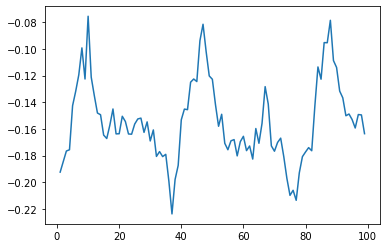

In [227]:
df_edge_features_train.iloc[1:100, 48].plot()

<AxesSubplot:>

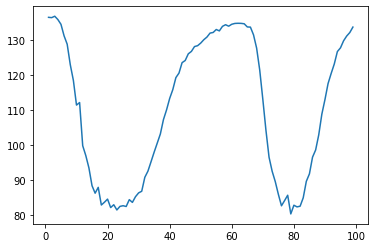

In [228]:
df_edge_features_val.iloc[1:100, 48].plot()

<AxesSubplot:>

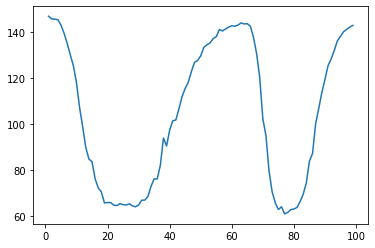

In [229]:
df_edge_features_test.iloc[1:100, 48].plot()

# Z-score

In [385]:
df_edge_features_train

,nose-left_eye-start_x,nose-left_eye-start_y,nose-left_eye-end_x,nose-left_eye-end_y,nose-right_eye-start_x,nose-right_eye-start_y,nose-right_eye-end_x,nose-right_eye-end_y,nose-left_shoulder-start_x,nose-left_shoulder-start_y,...,right_hip-right_knee-end_x,right_hip-right_knee-end_y,left_knee-left_ankle-start_x,left_knee-left_ankle-start_y,left_knee-left_ankle-end_x,left_knee-left_ankle-end_y,right_knee-right_ankle-start_x,right_knee-right_ankle-start_y,right_knee-right_ankle-end_x,right_knee-right_ankle-end_y
0,-0.000259,0.727646,-0.012028,0.701749,-0.000259,0.727646,-0.016710,0.728397,-0.000259,0.727646,...,-0.128220,0.083323,-0.064769,-0.025976,-0.048545,0.022317,-0.128220,0.083323,-0.181815,0.201253
1,-0.007332,0.752797,-0.036936,0.713345,-0.007332,0.752797,-0.015622,0.721302,-0.007332,0.752797,...,-0.131076,0.159245,-0.053926,0.052569,-0.086711,0.073812,-0.131076,0.159245,-0.204132,0.309904
2,-0.005889,0.666638,-0.025661,0.654273,-0.005889,0.666638,-0.014672,0.679266,-0.005889,0.666638,...,-0.137224,0.189192,-0.057454,0.066325,-0.079163,0.083192,-0.137224,0.189192,-0.204301,0.301690
3,-0.004585,0.671383,-0.019545,0.642021,-0.004585,0.671383,-0.014652,0.663518,-0.004585,0.671383,...,-0.138129,0.123012,-0.060599,0.050559,-0.088525,0.086457,-0.138129,0.123012,-0.199784,0.306177
4,-0.013036,0.706631,-0.030793,0.669053,-0.013036,0.706631,-0.027784,0.695391,-0.013036,0.706631,...,-0.134896,0.177944,-0.045789,0.095685,-0.097312,0.093940,-0.134896,0.177944,-0.191578,0.301934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39803,-1.803362,-0.148113,-1.817713,-0.161576,-1.803362,-0.148113,-1.804989,-0.164729,-1.803362,-0.148113,...,-1.852464,-0.379459,-1.756064,-0.409912,-1.726035,-0.352919,-1.852464,-0.379459,-1.928657,-0.173166
39804,-1.818092,-0.190989,-1.827321,-0.179134,-1.818092,-0.190989,-1.823537,-0.165233,-1.818092,-0.190989,...,-1.857503,-0.367117,-1.760755,-0.379892,-1.725860,-0.338865,-1.857503,-0.367117,-1.929064,-0.177842
39805,-1.835840,-0.176683,-1.837769,-0.171323,-1.835840,-0.176683,-1.838350,-0.169604,-1.835840,-0.176683,...,-1.852944,-0.370482,-1.760032,-0.386364,-1.729148,-0.330951,-1.852944,-0.370482,-1.929620,-0.177189
39806,-1.822916,-0.160926,-1.833670,-0.145088,-1.822916,-0.160926,-1.824270,-0.135591,-1.822916,-0.160926,...,-1.853929,-0.398993,-1.766817,-0.435797,-1.719795,-0.334994,-1.853929,-0.398993,-1.930041,-0.172947


In [230]:
df_edge_features_train = df_edge_features_train[name_combinations].astype(float).apply(stats.zscore)
df_edge_features_val = df_edge_features_val[name_combinations].astype(float).apply(stats.zscore)
df_edge_features_test = df_edge_features_test[name_combinations].astype(float).apply(stats.zscore)

<AxesSubplot:>

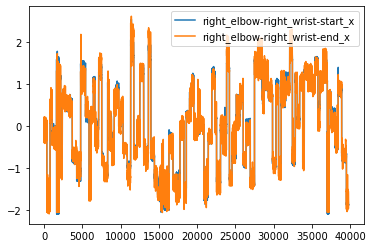

In [231]:
df_edge_features_train.iloc[:,[48, 50]].plot()

<AxesSubplot:>

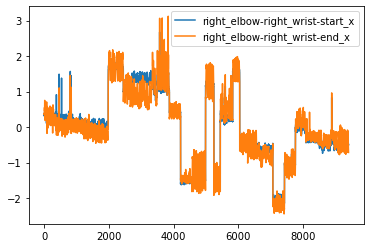

In [232]:
df_edge_features_val.iloc[:,[48, 50]].plot()

<AxesSubplot:>

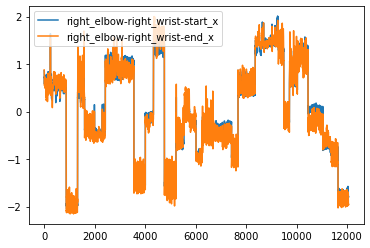

In [233]:
df_edge_features_test.iloc[:,[48, 50]].plot()

Text(0.5, 1.0, 'z-scored edge features')

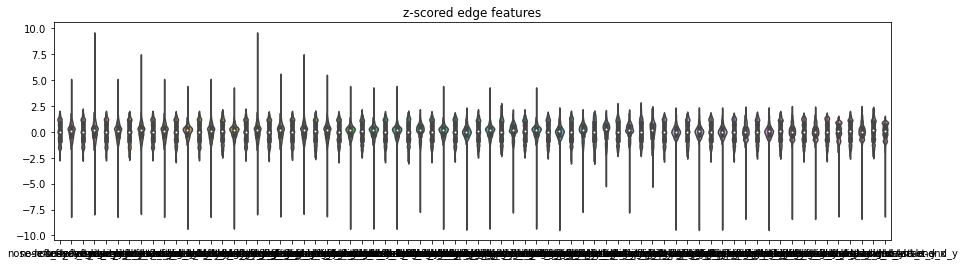

In [220]:
# sanity check
plt.figure(figsize=(15, 4))
ax = sns.violinplot(data=df_edge_features_train)
plt.title("z-scored edge features")

Text(0.5, 1.0, 'z-scored edge features')

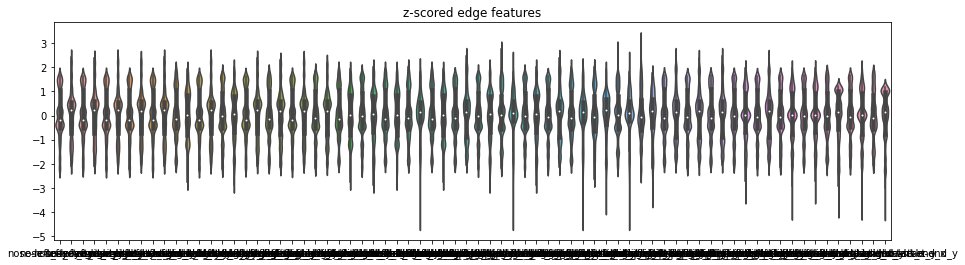

In [234]:
# sanity check
plt.figure(figsize=(15, 4))
ax = sns.violinplot(data=df_edge_features_val)
plt.title("z-scored edge features")

Text(0.5, 1.0, 'z-scored edge features')

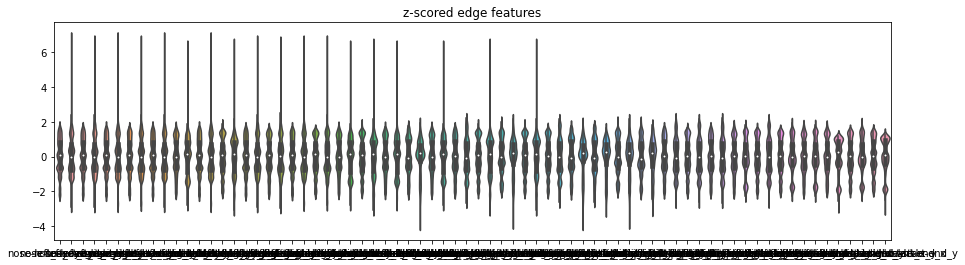

In [235]:
# sanity check
plt.figure(figsize=(15, 4))
ax = sns.violinplot(data=df_edge_features_test)
plt.title("z-scored edge features")

In [272]:
import pickle as pkl

with open('data/df_edge_features_train.pkl', 'wb') as f:
  pkl.dump(df_edge_features_train, f)
with open('data/df_edge_features_val.pkl', 'wb') as f:
  pkl.dump(df_edge_features_val, f)
with open('data/df_edge_features_test.pkl', 'wb') as f:
  pkl.dump(df_edge_features_test, f)


# keras tuner for LSTM

## create window generator object for making time series datasetes for keras

In [ ]:
class WindowGenerator():
  '''produces index slices for sliding windows
  label_columns needs to be more than one term or else will do character splitting
  '''
  
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}

    if isinstance(train_df, pd.Series):
      self.column_indices = {label_columns[0]: 0}

    else:
      self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
name_combinations.index('right_elbow-right_wrist-start_x')

In [ ]:
name_combinations[48]

In [246]:
train_df.iloc[:,[48, 48]]

,right_elbow-right_wrist-start_x,right_elbow-right_wrist-start_x
31765,0.908171,0.908171
24405,-1.254870,-1.254870
25356,0.163807,0.163807
6822,0.151170,0.151170
22235,1.191960,1.191960
...,...,...
8020,-1.178341,-1.178341
36622,1.072565,1.072565
16782,-0.560896,-0.560896
34433,1.276699,1.276699


In [247]:
w1_armfeatures_to1 = WindowGenerator(input_width=90, label_width=1, shift=30,
                                  train_df=df_edge_features_train.iloc[:,[48, 48]],
                                  val_df=df_edge_features_val.iloc[:,[48, 48]],
                                  test_df=df_edge_features_test.iloc[:,[48, 48]],
                                  label_columns=['right_elbow-right_wrist-start_x'])
w1_armfeatures_to1

Total window size: 120
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Label indices: [119]
Label column name(s): ['right_elbow-right_wrist-start_x']

In [211]:
w2_ds_rightarm = WindowGenerator(input_width=150, label_width=1, shift=150,
                      train_df=train_df.iloc[:,48:52], val_df=val_df.iloc[:,48:52], test_df=test_df.iloc[:,48:52],
                     label_columns=['right_elbow-right_wrist-start_x'])



In [ ]:
w2_ds_rightarm

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  
  if self.label_columns is not None:
   
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [248]:
for example_inputs, example_labels in w1_armfeatures_to1.test.take(3):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 90, 2)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 90, 2)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 90, 2)
Labels shape (batch, time, features): (32, 1, 1)


In [249]:
example_inputs

<tf.Tensor: shape=(32, 90, 2), dtype=float32, numpy=
array([[[-1.5672829 , -1.5672829 ],
        [-1.5742188 , -1.5742188 ],
        [-1.5567614 , -1.5567614 ],
        ...,
        [-1.5032874 , -1.5032874 ],
        [-1.5067912 , -1.5067912 ],
        [-1.5131558 , -1.5131558 ]],

       [[ 1.3266994 ,  1.3266994 ],
        [ 1.3463786 ,  1.3463786 ],
        [ 1.3002251 ,  1.3002251 ],
        ...,
        [ 1.3964357 ,  1.3964357 ],
        [ 1.3941587 ,  1.3941587 ],
        [ 1.4022233 ,  1.4022233 ]],

       [[-1.5389618 , -1.5389618 ],
        [-1.5393671 , -1.5393671 ],
        [-1.533353  , -1.533353  ],
        ...,
        [-1.478635  , -1.478635  ],
        [-1.5007721 , -1.5007721 ],
        [-1.5065236 , -1.5065236 ]],

       ...,

       [[-0.33135095, -0.33135095],
        [-0.31993586, -0.31993586],
        [-0.35192242, -0.35192242],
        ...,
        [-0.34397182, -0.34397182],
        [-0.32601798, -0.32601798],
        [-0.31504667, -0.31504667]],

       [[ 

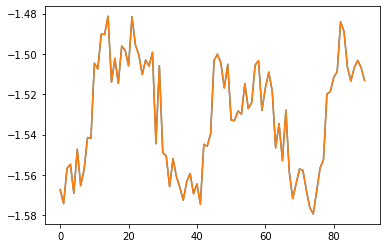

In [250]:
plt.plot(example_inputs[0, :, :])

## set up model compiler, performance metrics

In [370]:
def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                # optimizer=tf.optimizers.SGD(),
                metrics=[tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [ ]:
# dicts to store performance metrics
val_performance = {}
performance = {}

# focus on hand, elbow
label_index = 48

In [ ]:
# to test baseline runs
MAX_EPOCHS = 3

## baseline

In [ ]:
# baseline
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline()

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


In [ ]:
# store
val_performance['Baseline'] = baseline.evaluate(w1.val)
performance['Baseline'] = baseline.evaluate(w1.test, verbose=0)

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(linear, w1)

val_performance['Linear'] = linear.evaluate(w1.val)
performance['Linear'] = linear.evaluate(w1.test, verbose=0)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, w1)

val_performance['Dense'] = dense.evaluate(w1.val)
performance['Dense'] = dense.evaluate(w1.test, verbose=0)

## test out LSTM

In [209]:
MAX_EPOCHS = 2

In [ ]:
lstm_model = tf.keras.models.Sequential([
    
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, w1_armfeatures_to1)


In [ ]:
import IPython
import IPython.display

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w2_ds_rightarm.val)
performance['LSTM'] = lstm_model.evaluate(w2_ds_rightarm.test, verbose=0)

In [ ]:
performance

#### test out keras tuner

In [251]:
from tensorflow import keras
import keras_tuner as kt

def model_builder(hp):
  model = keras.Sequential()
  # model.add(keras.layers.Flatten(input_shape=(32, 1)))
  # model.add(keras.layers.LSTM(128, return_sequences=True, dropout=0.2))

  # LSTM layers
  hp_lstm_units = hp.Int('lstm_units_1', min_value=20, max_value=420, step=40)
  model.add(keras.layers.LSTM(units=hp_lstm_units, return_sequences=True, dropout=0.1))
  hp_lstm_units = hp.Int('lstm_units_2', min_value=20, max_value=420, step=40)
  model.add(keras.layers.LSTM(units=hp_lstm_units, return_sequences=True, dropout=0.1))

  # Dense layers
  hp_units = hp.Int('dense_units_1', min_value=10, max_value=100, step=30)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  hp_units = hp.Int('dense_units_2', min_value=10, max_value=100, step=30)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))

  # output seq length 1 
  model.add(keras.layers.Dense(1))
  
  # # Choose an optimal value between 32-512
  # hp_units = hp.Int('units', min_value=1, max_value=5, step=1)
  # model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  # model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                # loss=keras.losses.SparseCategoricalCrossentropy(),
                loss=keras.losses.MeanSquaredError(),
                metrics=['MeanSquaredError', 'CosineSimilarity'])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [252]:
tuner = kt.BayesianOptimization(model_builder,
                                objective='val_loss',
                                directory='my_dir',
                                project_name='kt_bayesian_3.4')


In [256]:
tuner.search(w1_armfeatures_to1.train, epochs=50,
              validation_data=w1_armfeatures_to1.val, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
{best_hps.get('lstm_units_1')}
{best_hps.get('lstm_units_2')}
{best_hps.get('dense_units_1')}
{best_hps.get('dense_units_2')}
{best_hps.get('learning_rate')}

""")

INFO:tensorflow:Oracle triggered exit

180
340
100
100
0.0001




In [254]:
# bayesian
tuner.results_summary()

Results summary
Results in my_dir\kt_bayesian_3.4
Showing 10 best trials
Trial summary
Hyperparameters:
lstm_units_1: 180
lstm_units_2: 340
dense_units_1: 100
dense_units_2: 100
learning_rate: 0.0001
Score: 0.29495805501937866
Trial summary
Hyperparameters:
lstm_units_1: 420
lstm_units_2: 260
dense_units_1: 10
dense_units_2: 100
learning_rate: 0.0001
Score: 0.29591354727745056
Trial summary
Hyperparameters:
lstm_units_1: 380
lstm_units_2: 260
dense_units_1: 100
dense_units_2: 10
learning_rate: 0.0001
Score: 0.29611191153526306
Trial summary
Hyperparameters:
lstm_units_1: 420
lstm_units_2: 20
dense_units_1: 100
dense_units_2: 100
learning_rate: 0.0001
Score: 0.2967042624950409
Trial summary
Hyperparameters:
lstm_units_1: 180
lstm_units_2: 20
dense_units_1: 10
dense_units_2: 100
learning_rate: 0.001
Score: 0.29801109433174133
Trial summary
Hyperparameters:
lstm_units_1: 420
lstm_units_2: 20
dense_units_1: 10
dense_units_2: 10
learning_rate: 0.0001
Score: 0.29844239354133606
Trial summary

In [257]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='kt_hyperband_3.4')


In [259]:
tuner.search(w1_armfeatures_to1.train, epochs=50,
              validation_data=w1_armfeatures_to1.val, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
{best_hps.get('lstm_units_1')}
{best_hps.get('lstm_units_2')}
{best_hps.get('dense_units_1')}
{best_hps.get('dense_units_2')}
{best_hps.get('learning_rate')}
""")

Trial 30 Complete [00h 07m 01s]
val_loss: 0.29810741543769836

Best val_loss So Far: 0.2954511344432831
Total elapsed time: 01h 17m 35s
INFO:tensorflow:Oracle triggered exit

140
420
40
70
0.0001



In [ ]:
# hyperband
tuner.results_summary()

# train LSTM model

In [273]:
MAX_EPOCHS = 100

In [375]:
lstm_model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(units=140, return_sequences=True, dropout=0.3),
    tf.keras.layers.LSTM(units=420, return_sequences=True, dropout=0.3),
    tf.keras.layers.LSTM(units=420, return_sequences=True, dropout=0.3),
    tf.keras.layers.LSTM(units=420, return_sequences=True, dropout=0.3),

    tf.keras.layers.Dense(units=40, activation='relu'),
    tf.keras.layers.Dense(units=70, activation='relu'),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dense(1)

])

history = compile_and_fit(lstm_model, w1_armfeatures_to1)

Epoch 1/100
1241/1241 [==============================] - 66s 48ms/step - loss: 0.3968 - mean_squared_error: 0.3968 - val_loss: 0.3122 - val_mean_squared_error: 0.3122
Epoch 2/100
1241/1241 [==============================] - 58s 47ms/step - loss: 0.3649 - mean_squared_error: 0.3649 - val_loss: 0.3073 - val_mean_squared_error: 0.3073
Epoch 3/100
1241/1241 [==============================] - 58s 47ms/step - loss: 0.3605 - mean_squared_error: 0.3605 - val_loss: 0.3094 - val_mean_squared_error: 0.3094
Epoch 4/100
1241/1241 [==============================] - 60s 48ms/step - loss: 0.3572 - mean_squared_error: 0.3572 - val_loss: 0.3057 - val_mean_squared_error: 0.3057
Epoch 5/100
1241/1241 [==============================] - 60s 48ms/step - loss: 0.3543 - mean_squared_error: 0.3543 - val_loss: 0.3102 - val_mean_squared_error: 0.3102
Epoch 6/100
1241/1241 [==============================] - 59s 48ms/step - loss: 0.3519 - mean_squared_error: 0.3519 - val_loss: 0.3157 - val_mean_squared_error: 0.315

In [380]:
import IPython
import IPython.display

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w1_armfeatures_to1.val)
performance['LSTM'] = lstm_model.evaluate(w1_armfeatures_to1.test, verbose=0)

291/291 [==============================] - 8s 24ms/step - loss: 0.3290 - mean_squared_error: 0.3290


In [381]:
performance

{'LSTM': [0.3152436316013336, 0.3152437210083008]}

Text(0.5, 1.0, 'model loss')

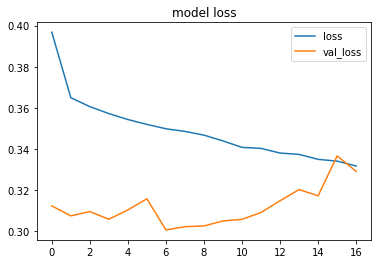

In [382]:
# plot training curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('model loss')

In [364]:
test_predict = lstm_model.predict(example_inputs)

In [365]:
example_inputs.shape

TensorShape([32, 90, 2])

In [366]:
test_predict.shape

(32, 90, 1)

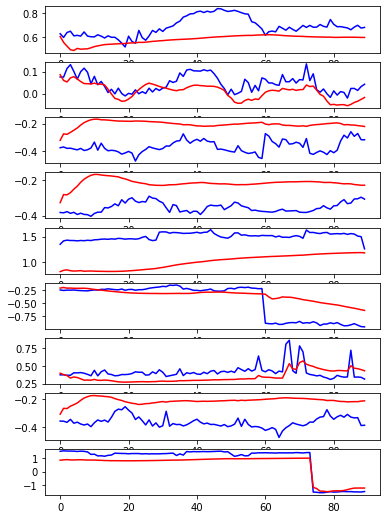

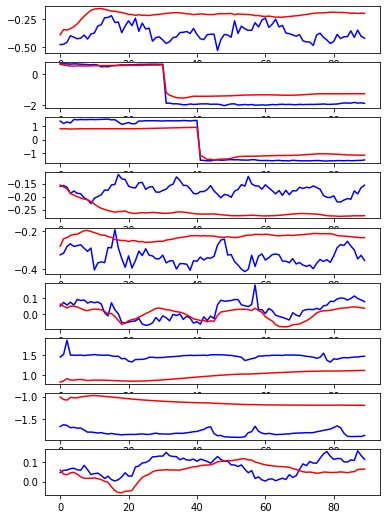

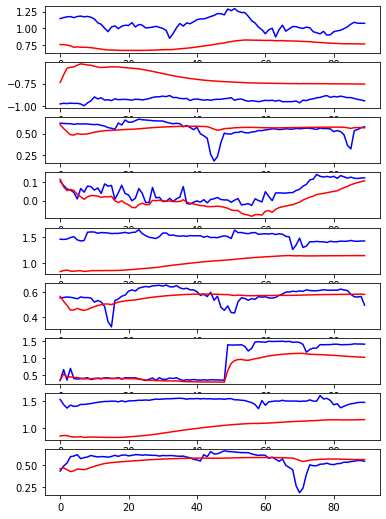

In [383]:
for test_example_inputs, test_example_labels in w1_armfeatures_to1.test.take(3):
  test_predicted_labels = lstm_model.predict(test_example_inputs)
  
  figure = plt.figure(figsize=(6,10))
  for subploti in range(1, 10):
    plt.subplot(10,1,subploti)
    plt.plot(test_example_inputs[subploti,:,0], color='blue')
    plt.plot(test_example_labels[subploti,:,:], color='green')
    plt.plot(test_predicted_labels[subploti,:,0], color='red')


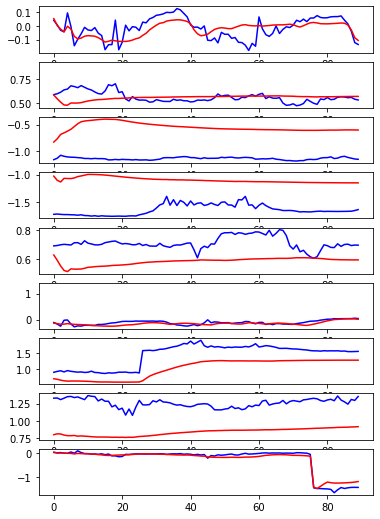

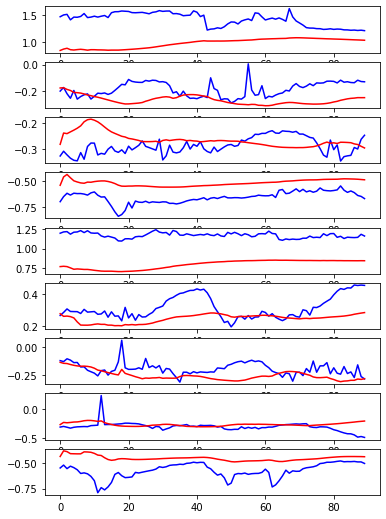

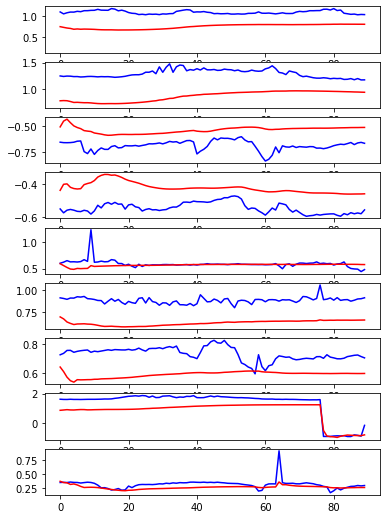

In [384]:
for train_example_inputs, train_example_labels in w1_armfeatures_to1.train.take(3):
  train_predicted_labels = lstm_model.predict(train_example_inputs)
  
  figure = plt.figure(figsize=(6,10))
  for subploti in range(1, 10):
    plt.subplot(10,1,subploti)
    plt.plot(train_example_inputs[subploti,:,0], color='blue')
    plt.plot(train_example_labels[subploti,:,:], color='green')
    plt.plot(train_predicted_labels[subploti,:,0], color='red')
